In [1]:
!uv pip install geopandas pandas pyarrow matplotlib shapely momepy numpy topojson ipywidgets
import geopandas as gpd
import math
import shapely
import shapely.plotting
import momepy
import pandas as pd
import numpy as np
import topojson as tp

Audited 9 packages in 11ms


In [2]:
filename = "02-55-5505-130_3.OG.parquet"

df = gpd.read_parquet(filename)
df["level"] = df["level"].astype("category")
df["type"] = df["type"].astype("category")
df["tid"] = np.arange(len(df))

# the current extraction logic is a bit messy with this => lets split for better analysis
# df["super_type"] = df["name"].map(lambda s: s.split(" | ")[0])
# df["sub_type_id"] = df["name"].map(lambda s: int(s.split("(")[1].strip(")")))
# df["sub_type"] = df["name"].map(lambda s: s.split("(")[0].split(" | ")[1]).astype("category")
df = df.rename(columns={"height": "height_geom"})  # todo: remove once reprocessed
df.drop("name", inplace=True, axis=1)
# df

In [3]:
# the generated metadata is pretty messy => lets clean it up before further looking at it
def fix_metadata(d: dict) -> dict:
    result = {}
    if not d:  # can also be None
        d = {}
    for k, v in d.items():
        if k == "None":
            for k2, v2 in fix_metadata(v).items():
                result[k2] = v2
        elif isinstance(v, dict):
            for k2, v2 in fix_metadata(v).items():
                result[k + "." + k2] = v2
        elif v is None or v.strip() in ["None", "-", "-_-", "-_", "_-", ""]:  # why though?
            result[k] = None
        elif v.strip() in ["True", "False"]:
            result[k] = bool(v)
        else:
            result[k] = v.strip()  # valid string
    return result


df["metadata"] = df["metadata"].map(fix_metadata)

In [4]:
df

metadata  height_geom  \
0    {'ADT_Pset_Door.OpenPercent': '50.0', 'ADT_Pse...        2.200   
1    {'ADT_Pset_Door.OpenPercent': '50.0', 'ADT_Pse...        2.200   
2    {'ADT_Pset_Door.OpenPercent': '50.0', 'ADT_Pse...        2.200   
3    {'ADT_Pset_Door.OpenPercent': '50.0', 'ADT_Pse...        2.200   
4    {'ADT_Pset_Door.OpenPercent': '50.0', 'ADT_Pse...        2.065   
..                                                 ...          ...   
255  {'ADT_Pset_Door': None, 'ADT_Pset_DoorStyle': ...          NaN   
256  {'ADT_Pset_Door': None, 'ADT_Pset_DoorStyle': ...          NaN   
257  {'ADT_Pset_Door': None, 'ADT_Pset_DoorStyle': ...          NaN   
258  {'ADT_Pset_Door': None, 'ADT_Pset_DoorStyle': ...          NaN   
259  {'ADT_Pset_Door': None, 'ADT_Pset_DoorStyle': ...          NaN   

                                              geometry     type level  tid  
0    POLYGON ((76532.721 77359.794, 76532.636 77359...     door     3    0  
1    POLYGON ((76526.225 77349.754, 76526.239 77350...     door     3    1  
2    POLYGON ((76533.025 77349.379, 76533.039 77349...     door     3    2  
3    POLYGON ((76554.864 77352.19, 76554.779 77351....     door     3    3  
4    POLYGON ((76557.632 77348.023, 76557.645 77348...     door     3    4  
..                                                 ...      ...   ...  ...  
255  POLYGON ((76538.195 77368.326, 76538.163 77368...  opening     3  255  
256  POLYGON ((76531.387 77370.67, 76531.355 77370....  opening     3  256  
257  POLYGON ((76574.503 77355.824, 76574.471 77355...  opening     3  257  
258  POLYGON ((76579.042 77354.262, 76579.009 77354...  opening     3  258  
259  POLYGON ((76524.58 77373.014, 76524.547 77372....  opening     3  259  

[260 rows x 6 columns]

In [5]:
doors = df[df["type"] == "door"].copy(deep=True)
doors["indoor"] = "door"
spaces = df[df["type"] == "space"].copy(deep=True)
spaces["indoor"] = "room"
openings = df[df["type"] == "opening"].copy(deep=True)

In [6]:
spaces = spaces.explode()  # we really don't want to deal with multipolygons

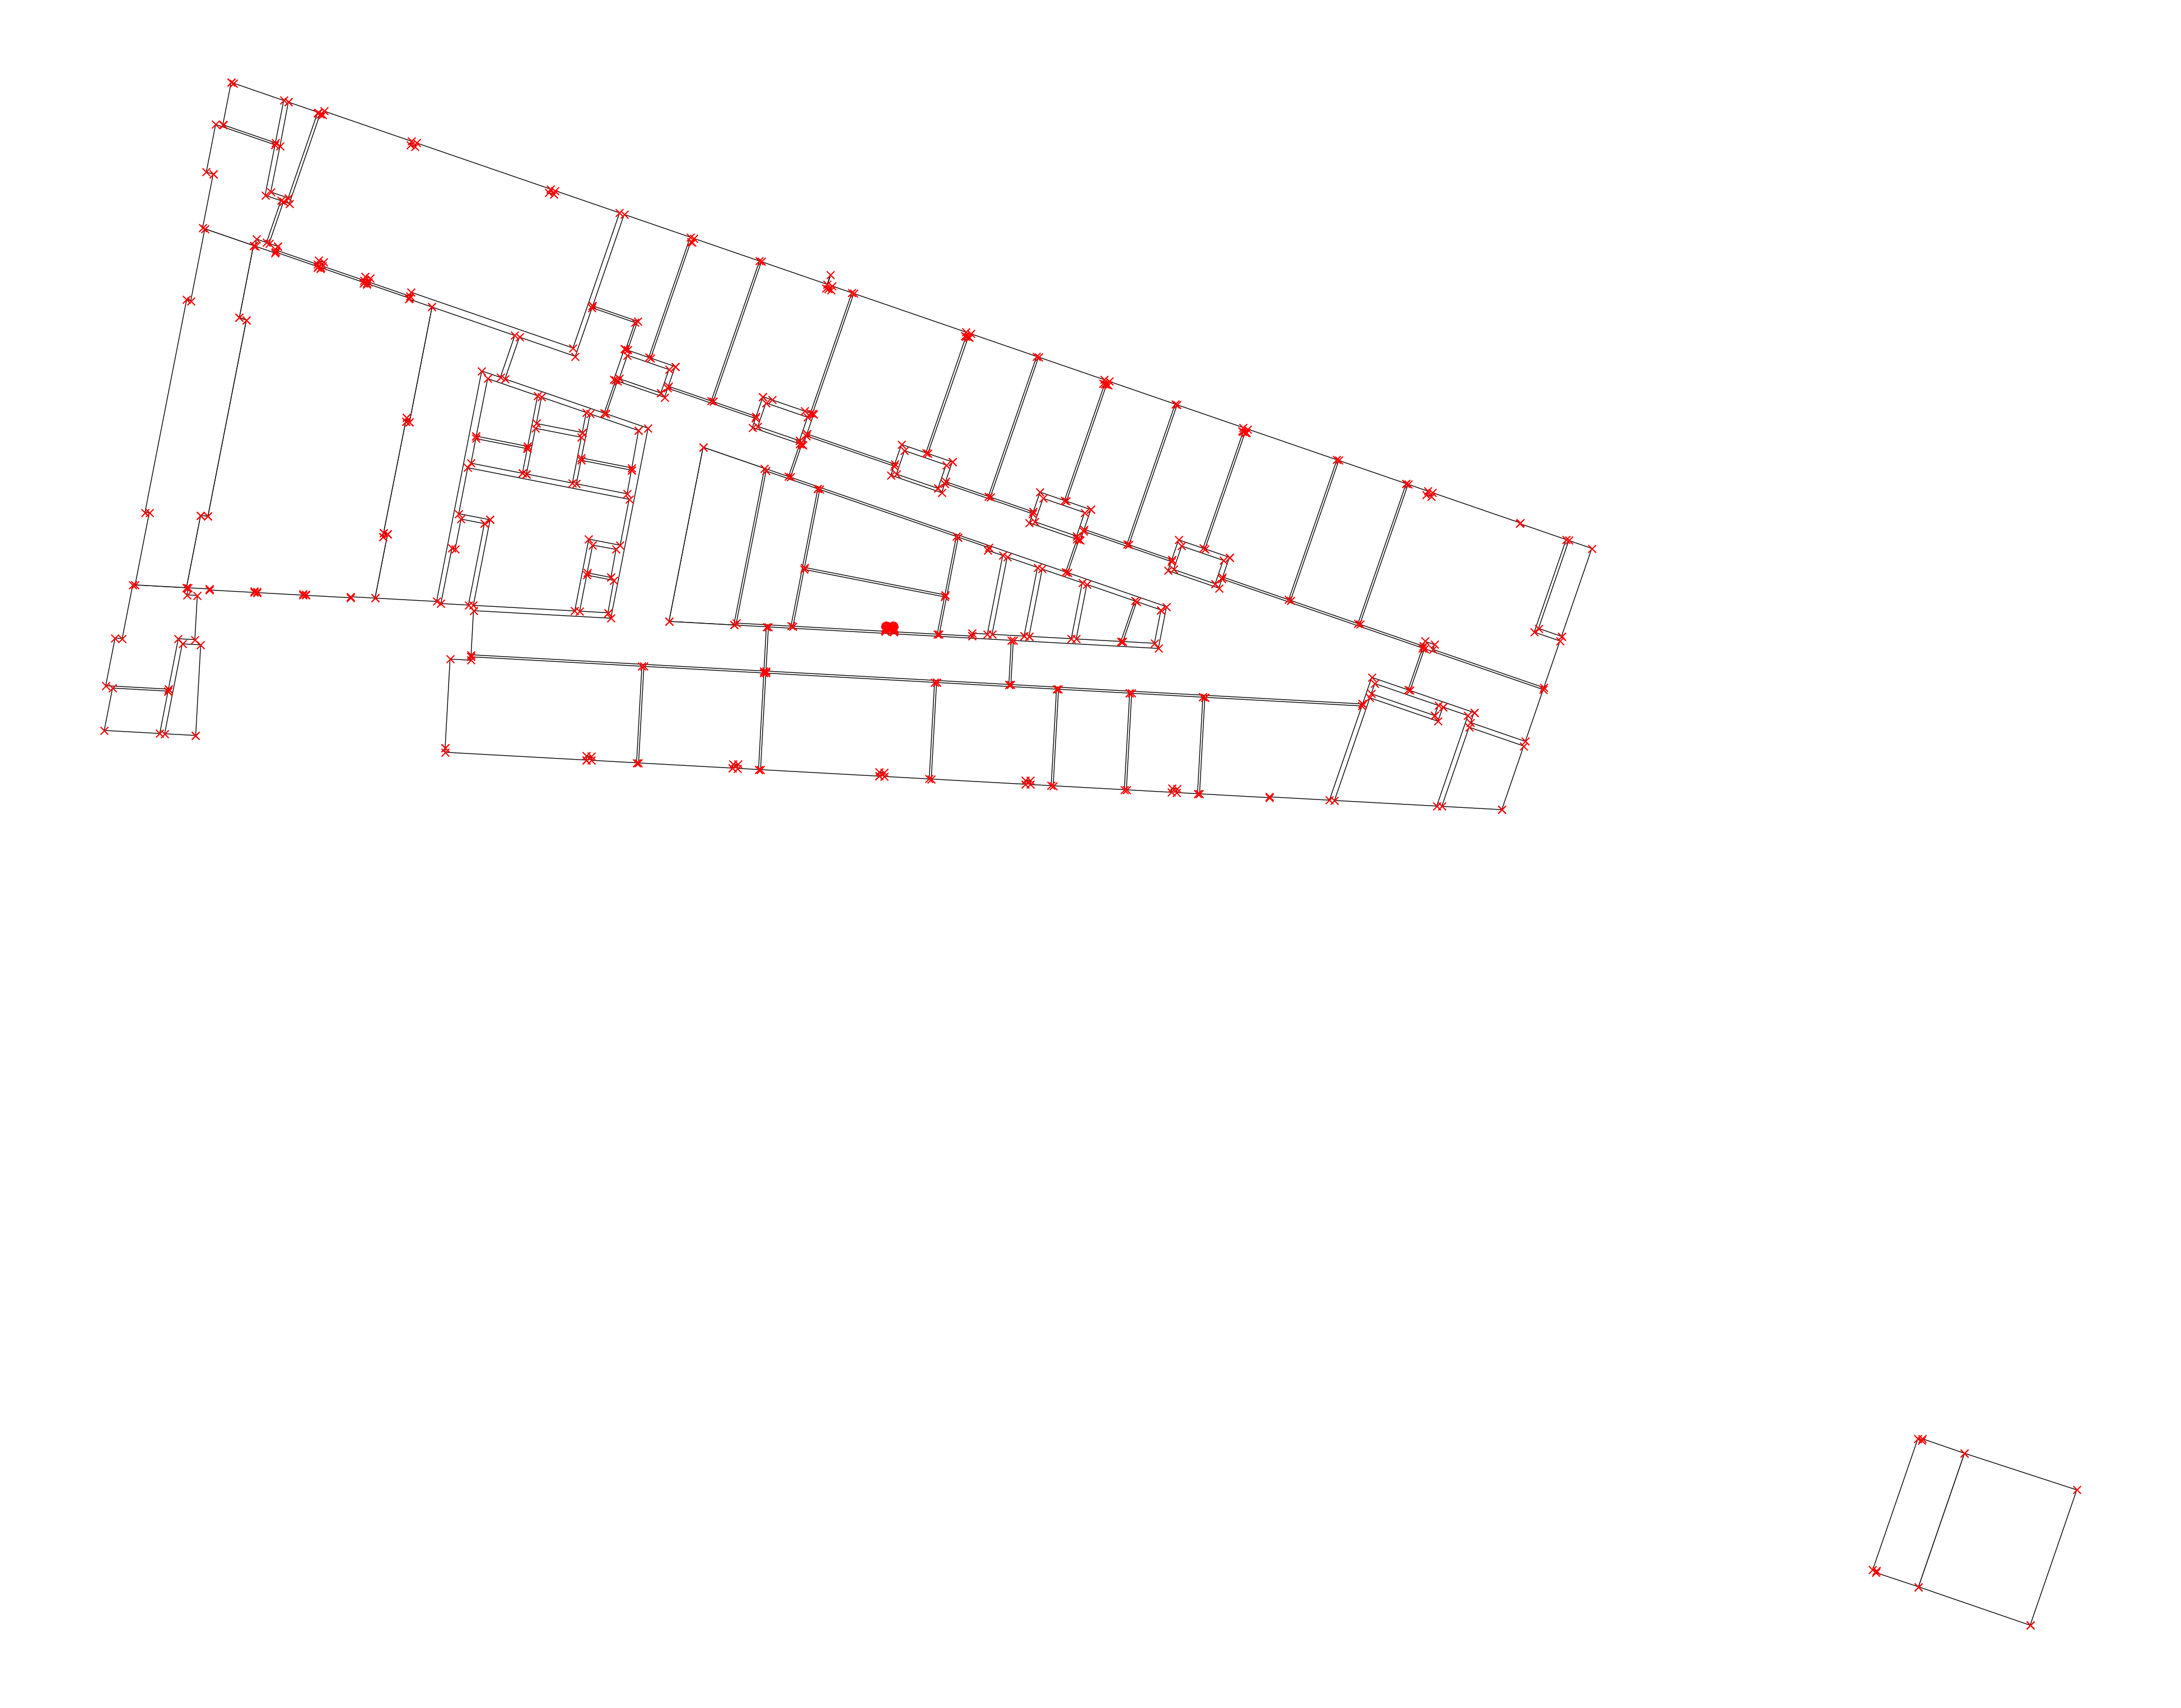

In [7]:
def visualise_points():
    ax = spaces.plot(color="white", edgecolor="black", figsize=(50, 50))
    ax.set_axis_off()
    gs = []
    for geom in spaces["geometry"]:
        for x, y in zip(*geom.exterior.coords.xy):
            point = shapely.Point(x, y)
            gs.append(point)
    gpd.GeoSeries(gs).plot(ax=ax, marker="x", color="red", markersize=100)


visualise_points()

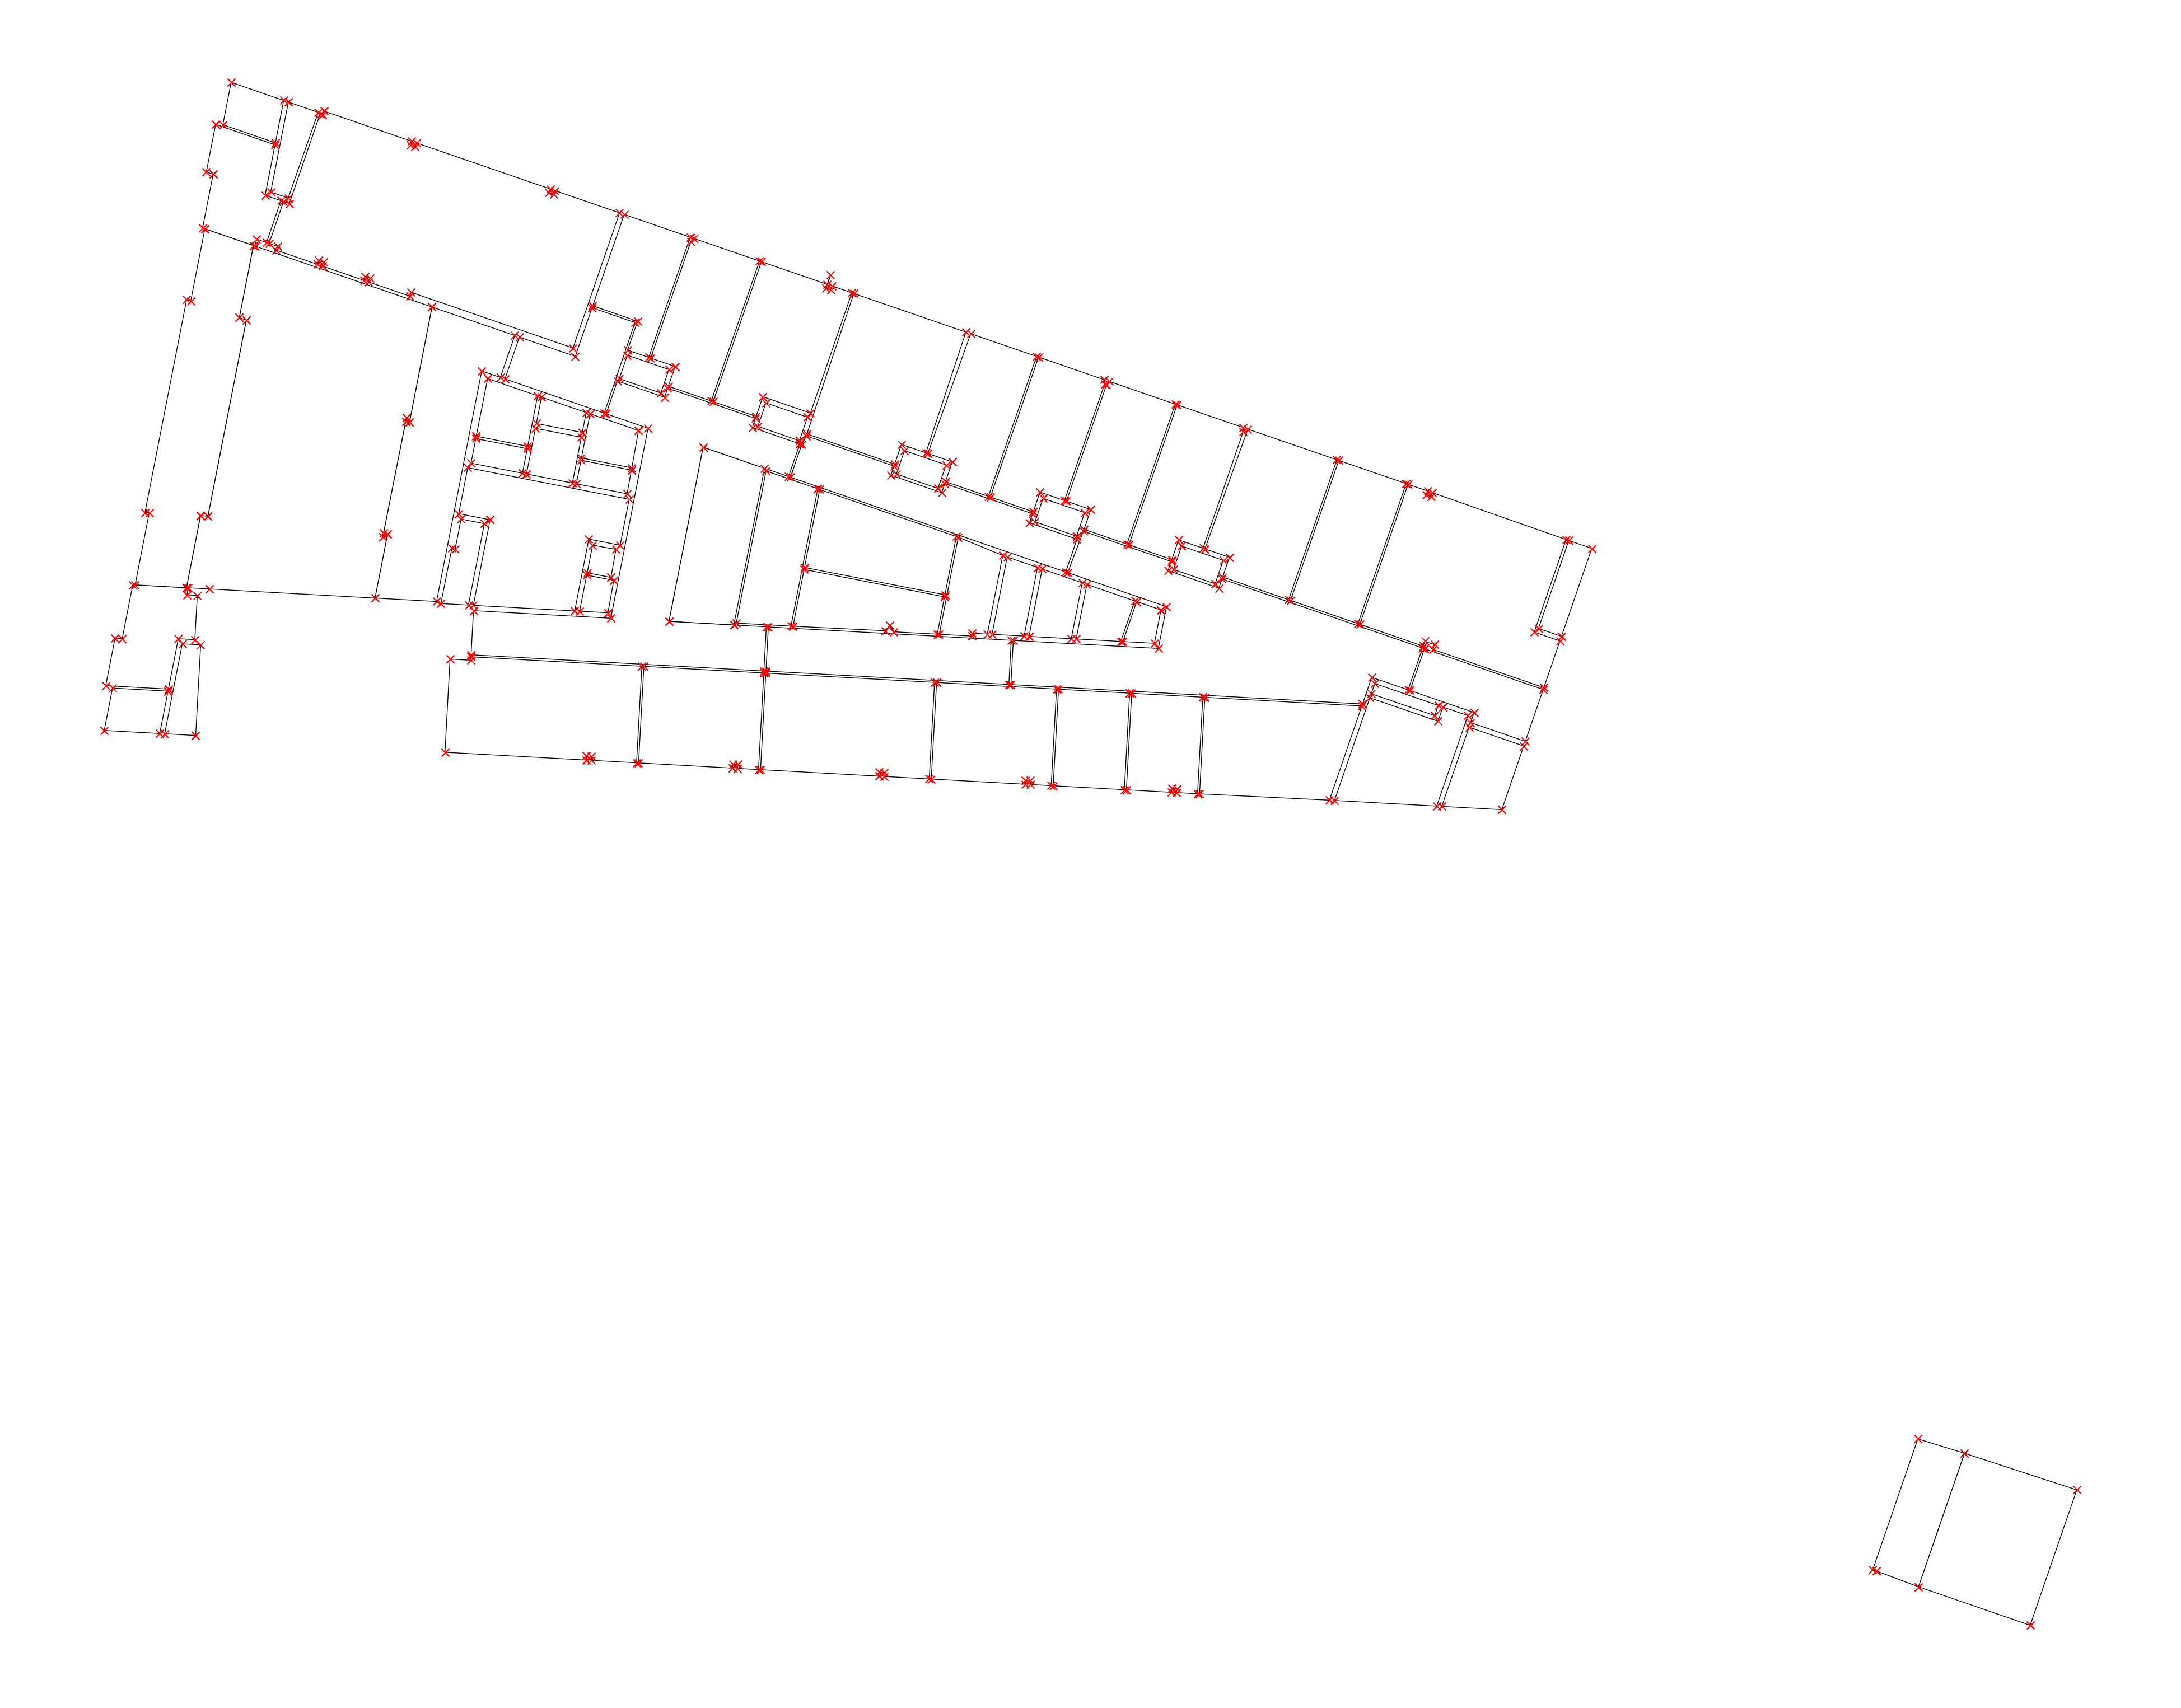

In [8]:
def simplify_shapes(inp_geom: gpd.GeoSeries) -> gpd.GeoSeries:
    return inp_geom.map(lambda g: shapely.simplify(g, tolerance=0.1))


spaces["geometry"] = simplify_shapes(spaces["geometry"])

visualise_points()

<Axes: >

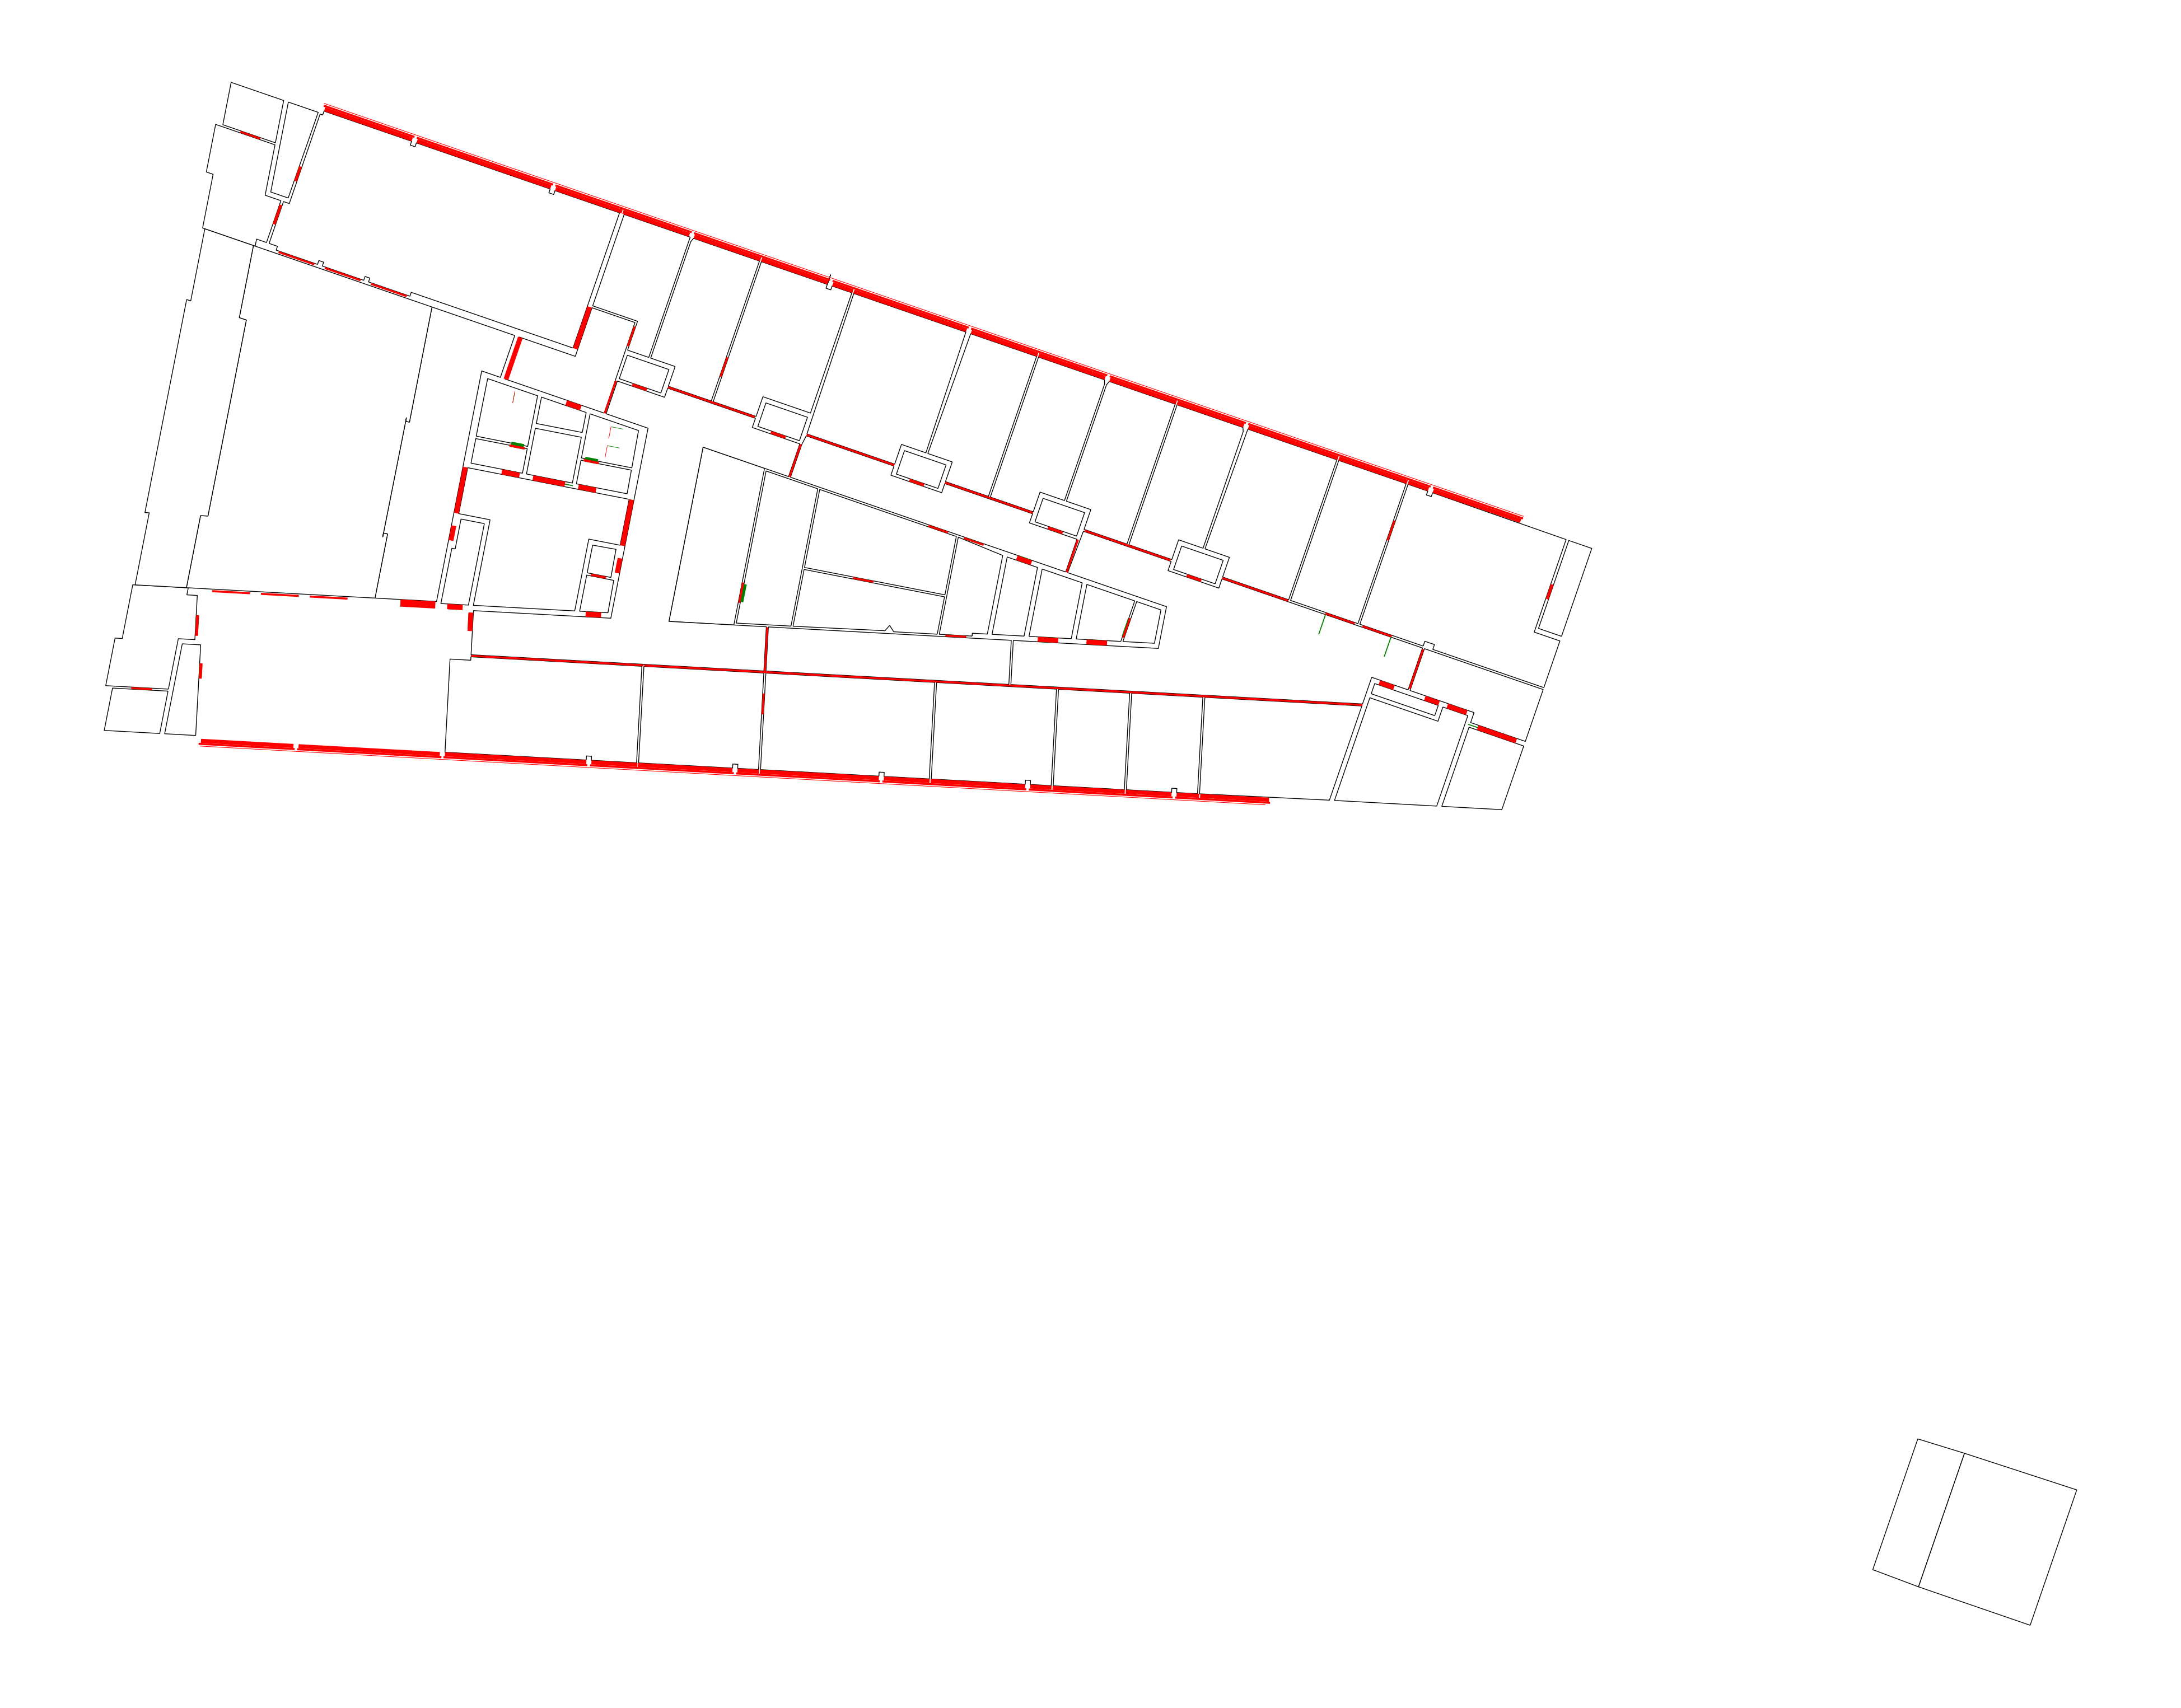

In [9]:
ax = spaces.plot(color="white", edgecolor="black", figsize=(50, 50))
ax.set_axis_off()
doors.plot(ax=ax, marker="x", color="green", markersize=100)
openings.plot(ax=ax, marker="x", color="red", markersize=100)

<Axes: >

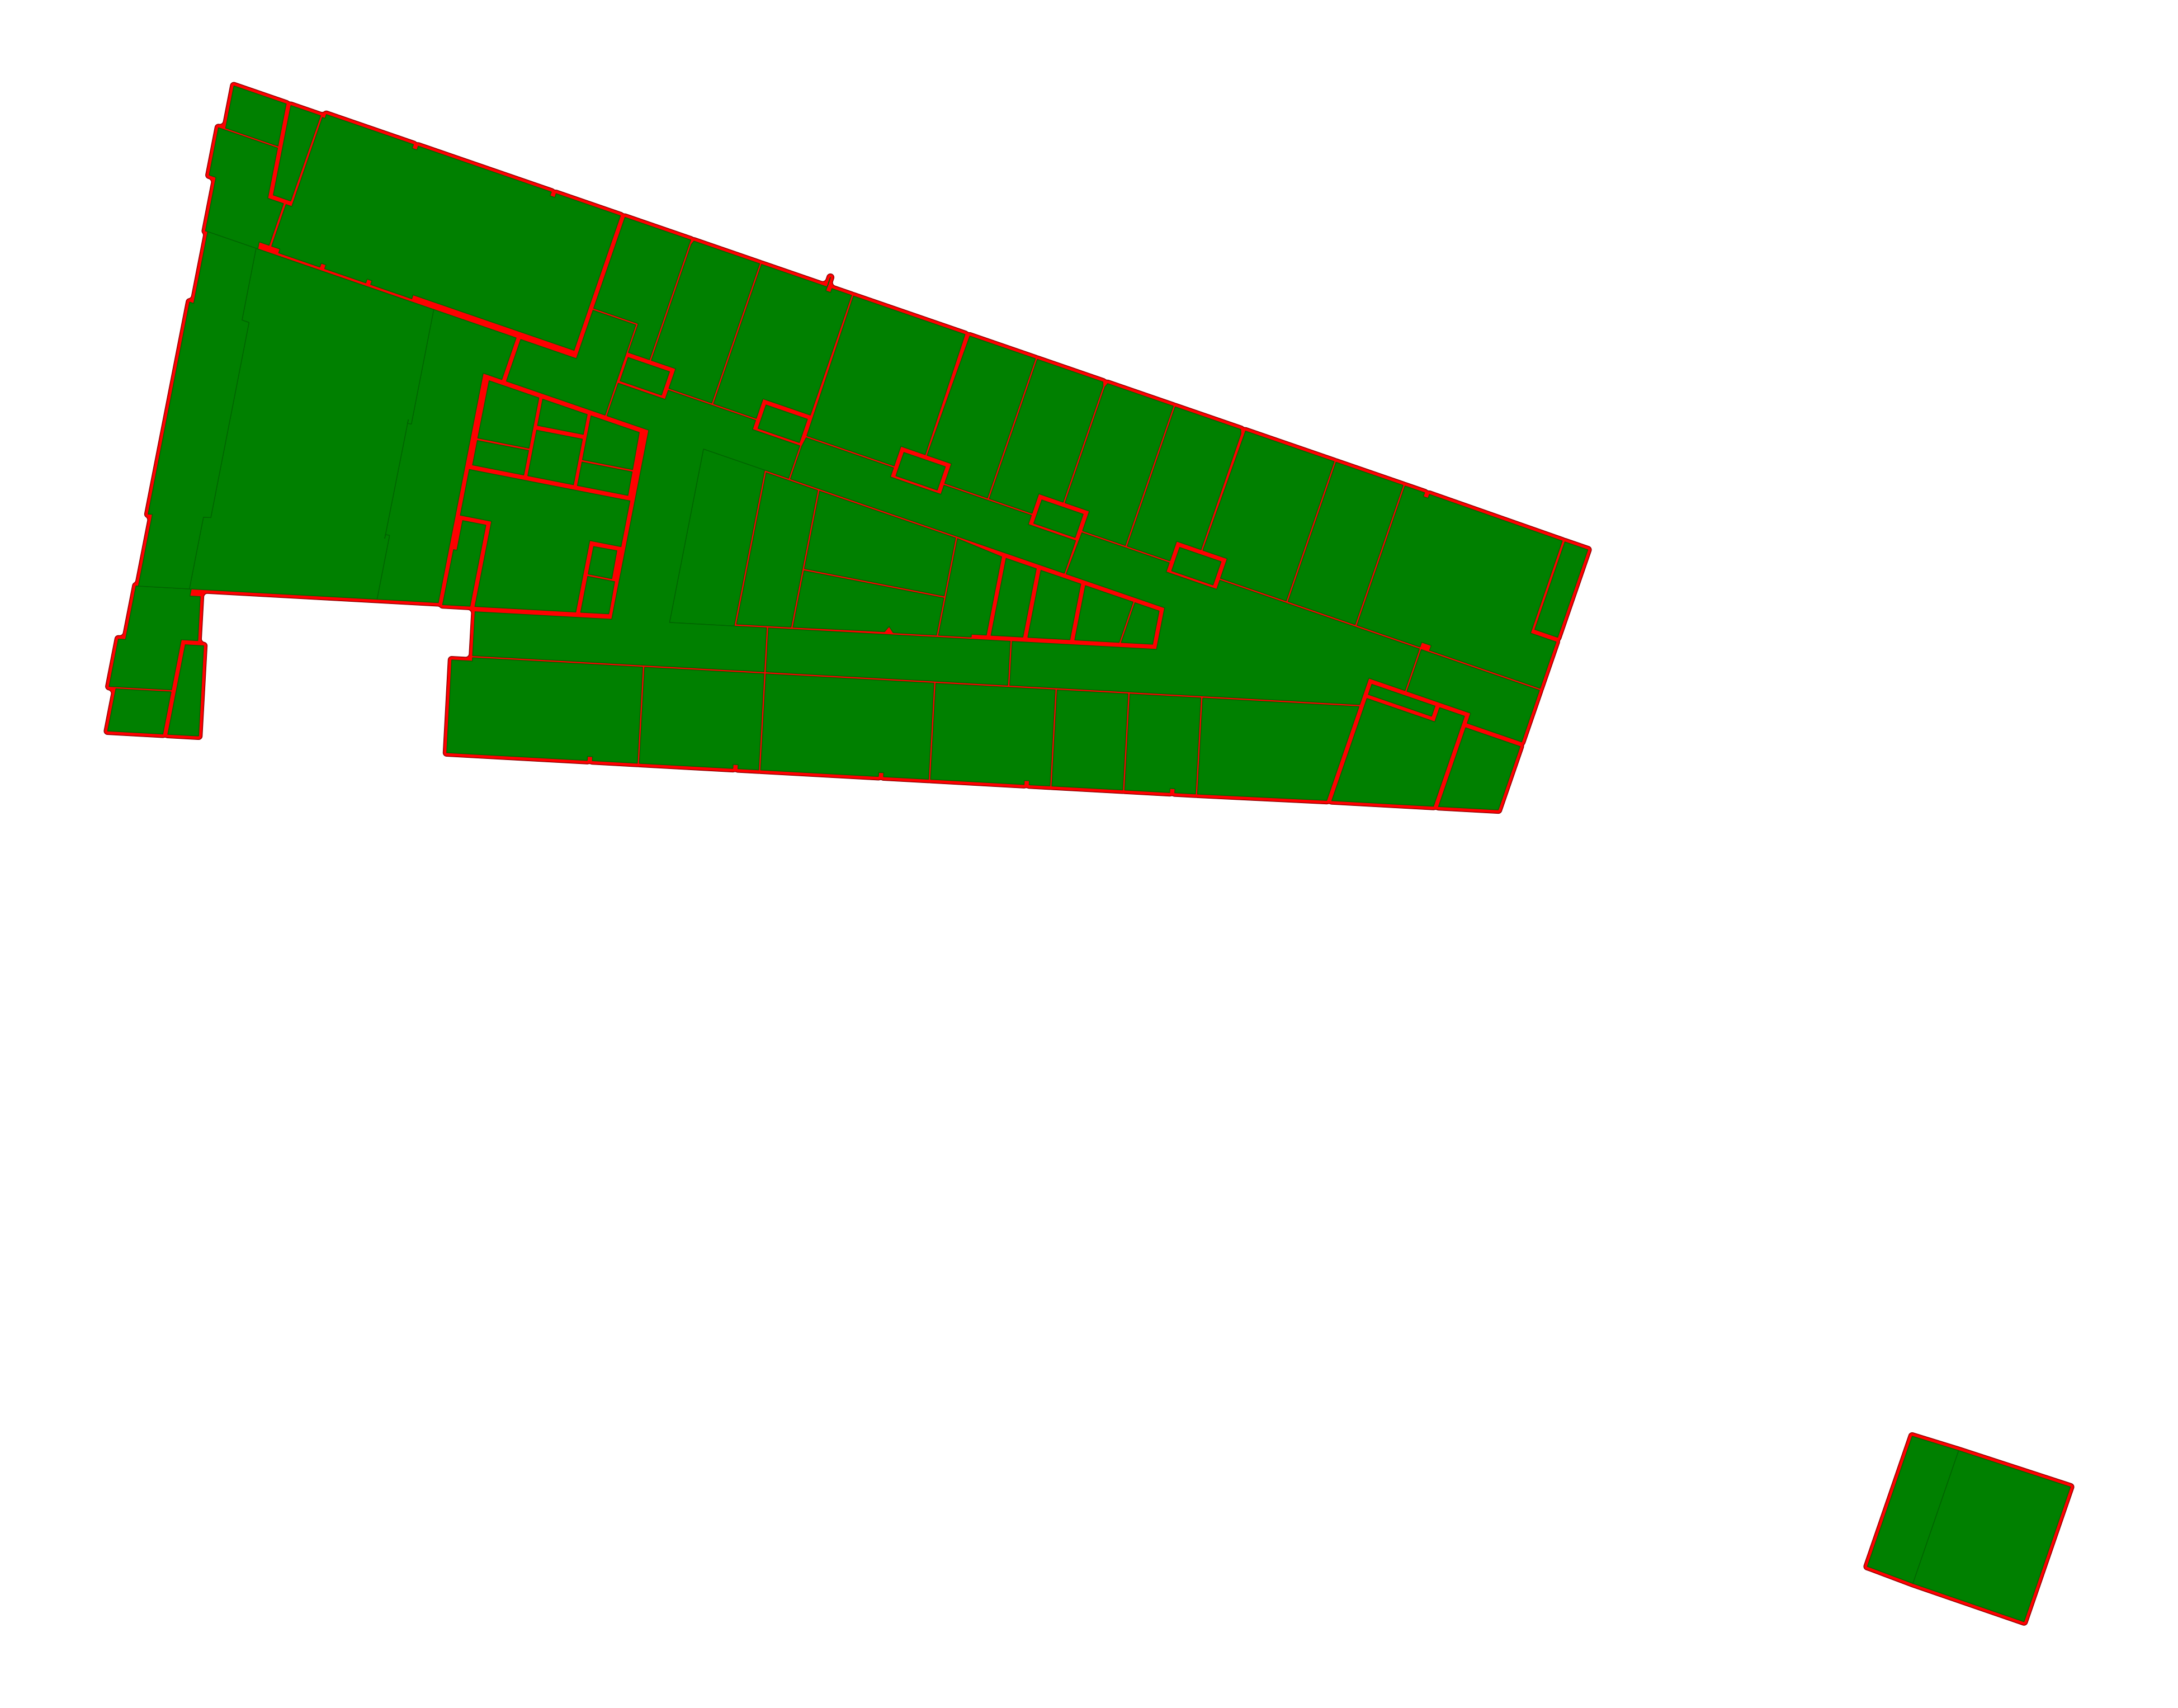

In [10]:
limit = gpd.GeoSeries(momepy.buffered_limit(spaces, buffer=0.35))
limit = gpd.GeoSeries(momepy.buffered_limit(limit, buffer=-0.35 / 2))
ax = limit.plot(color="red", edgecolor="darkred", figsize=(50, 50))
ax.set_axis_off()
spaces.plot(ax=ax, color="green", edgecolor="darkgreen")

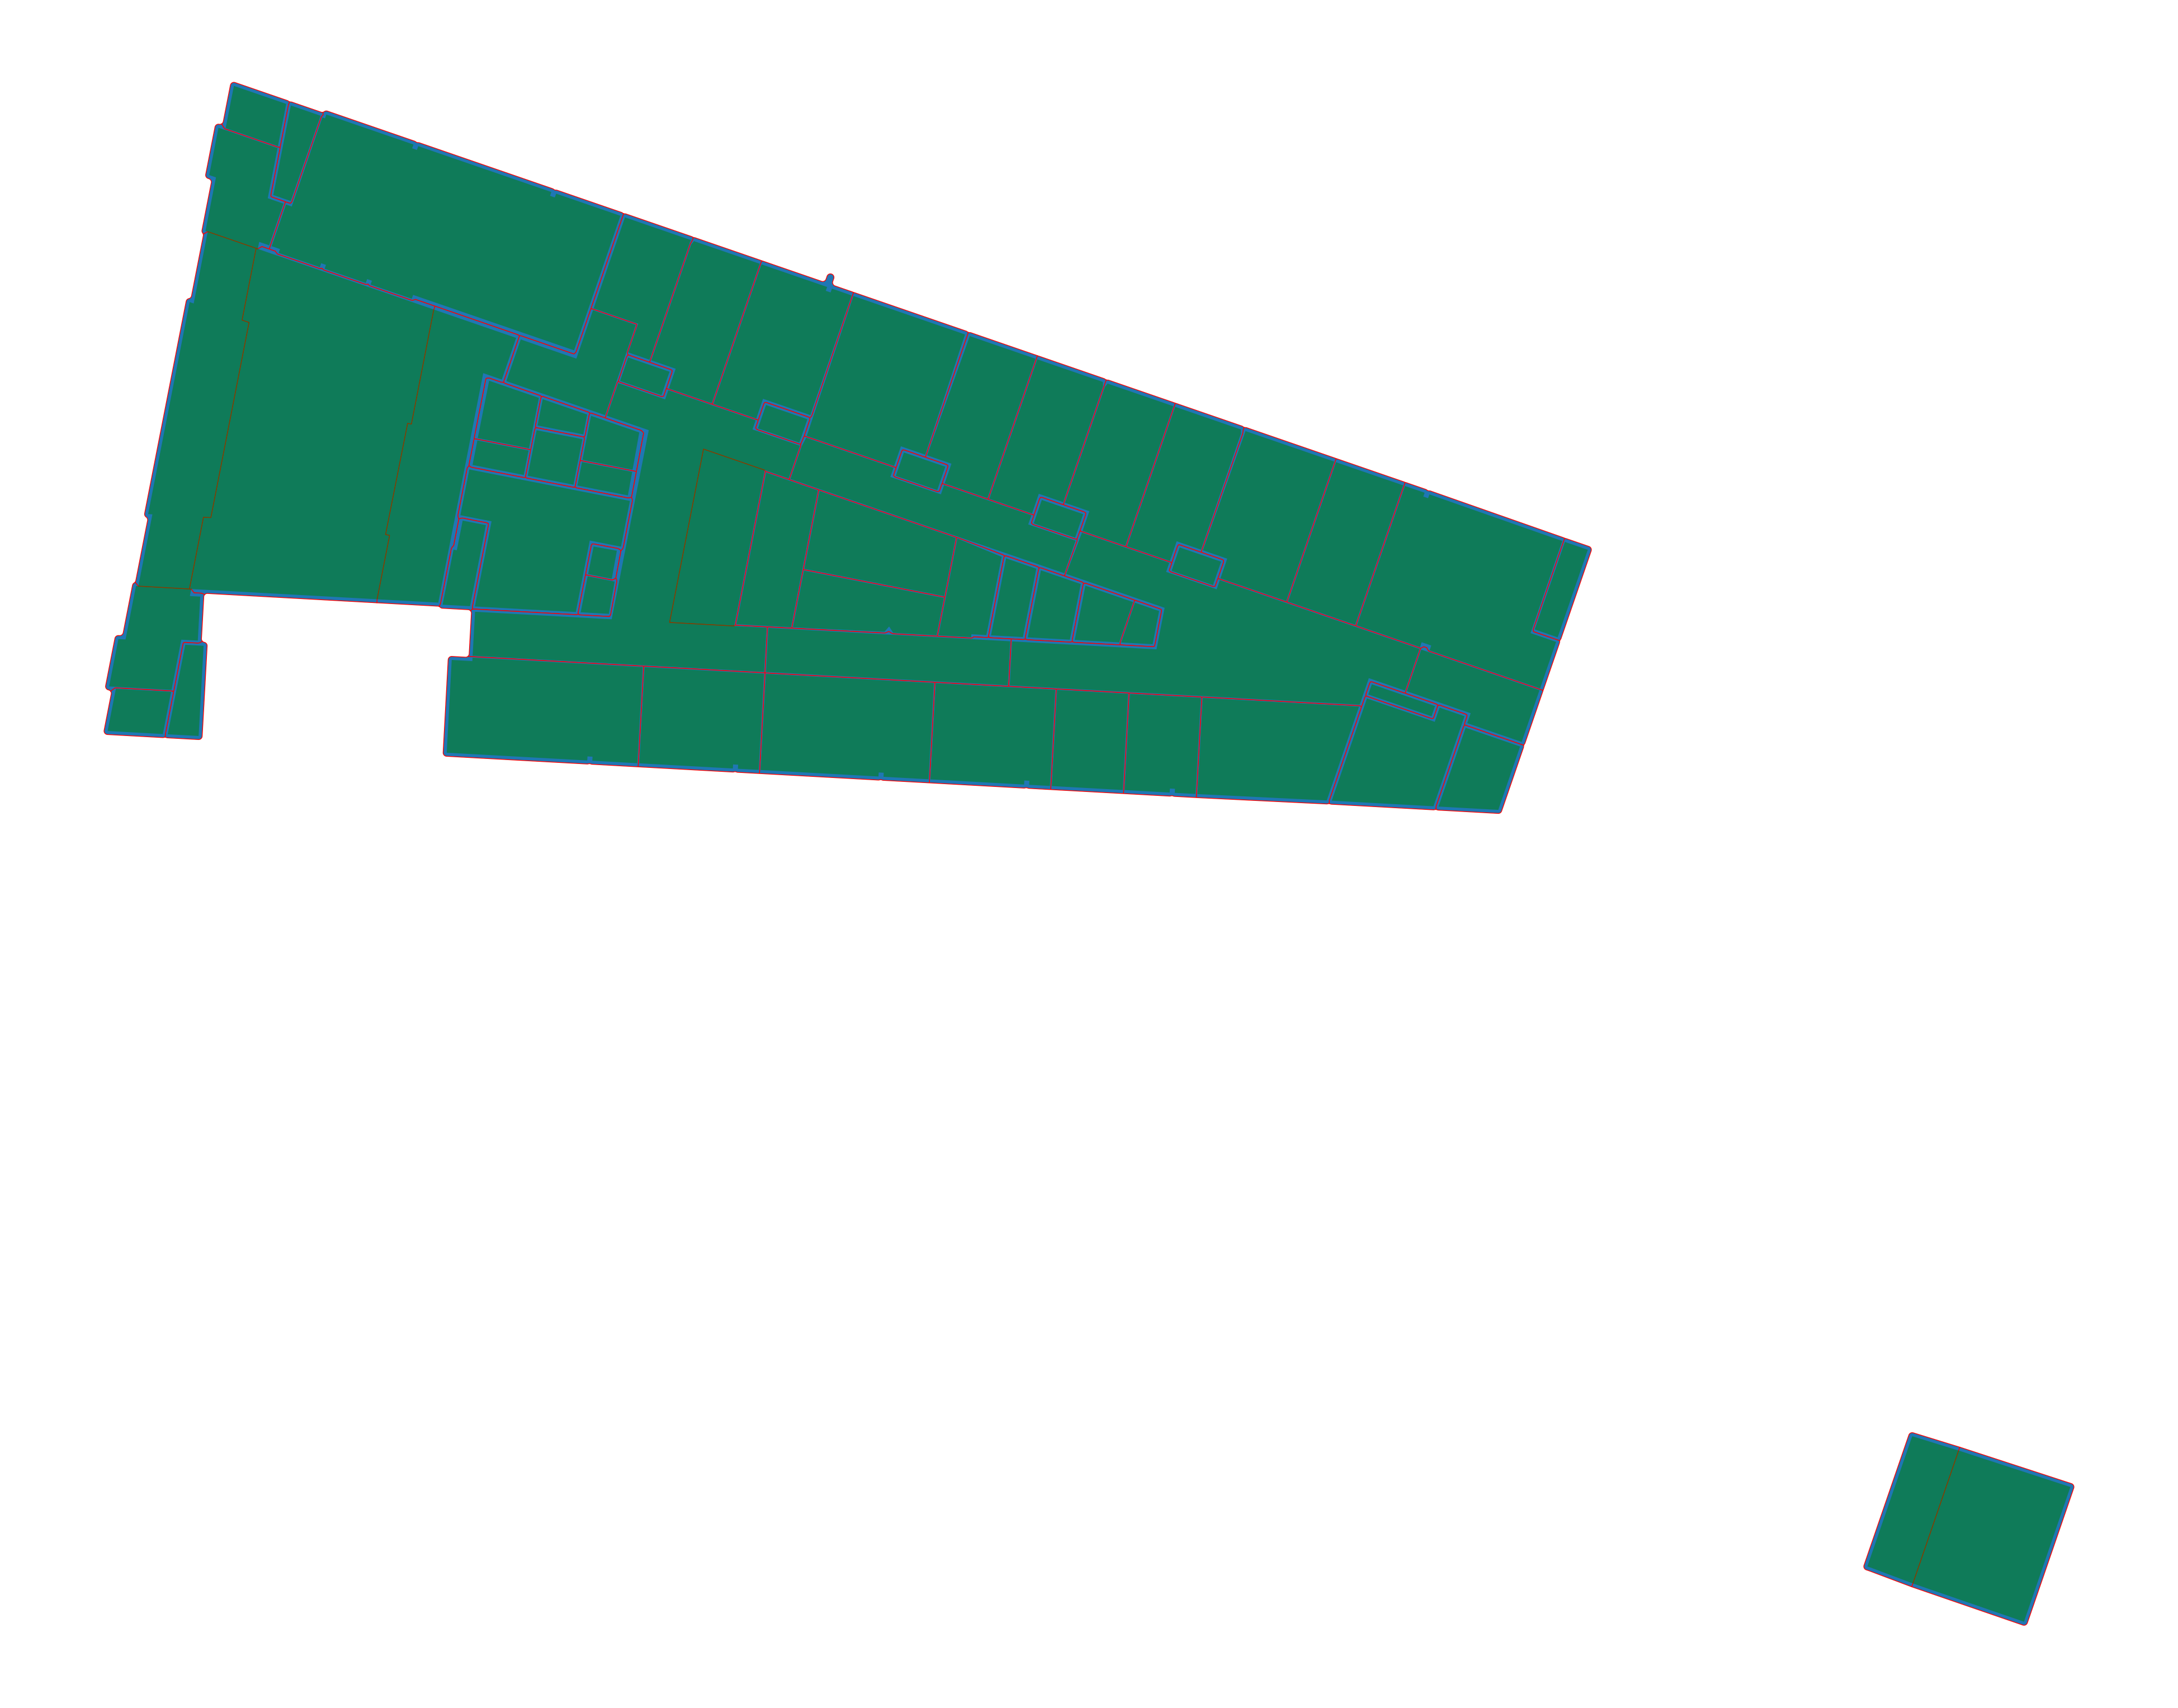

In [11]:
tessellation = momepy.enclosed_tessellation(spaces, enclosures=limit, shrink=0.01, segment=0.005, threshold=0.05)
# tessellation = gpd.GeoSeries(simplify_shapes(tessellation.geometry))
ax = tessellation.plot(edgecolor="red", figsize=(50, 50))
spaces.plot(ax=ax, color="green", alpha=0.5)
ax.set_axis_off()

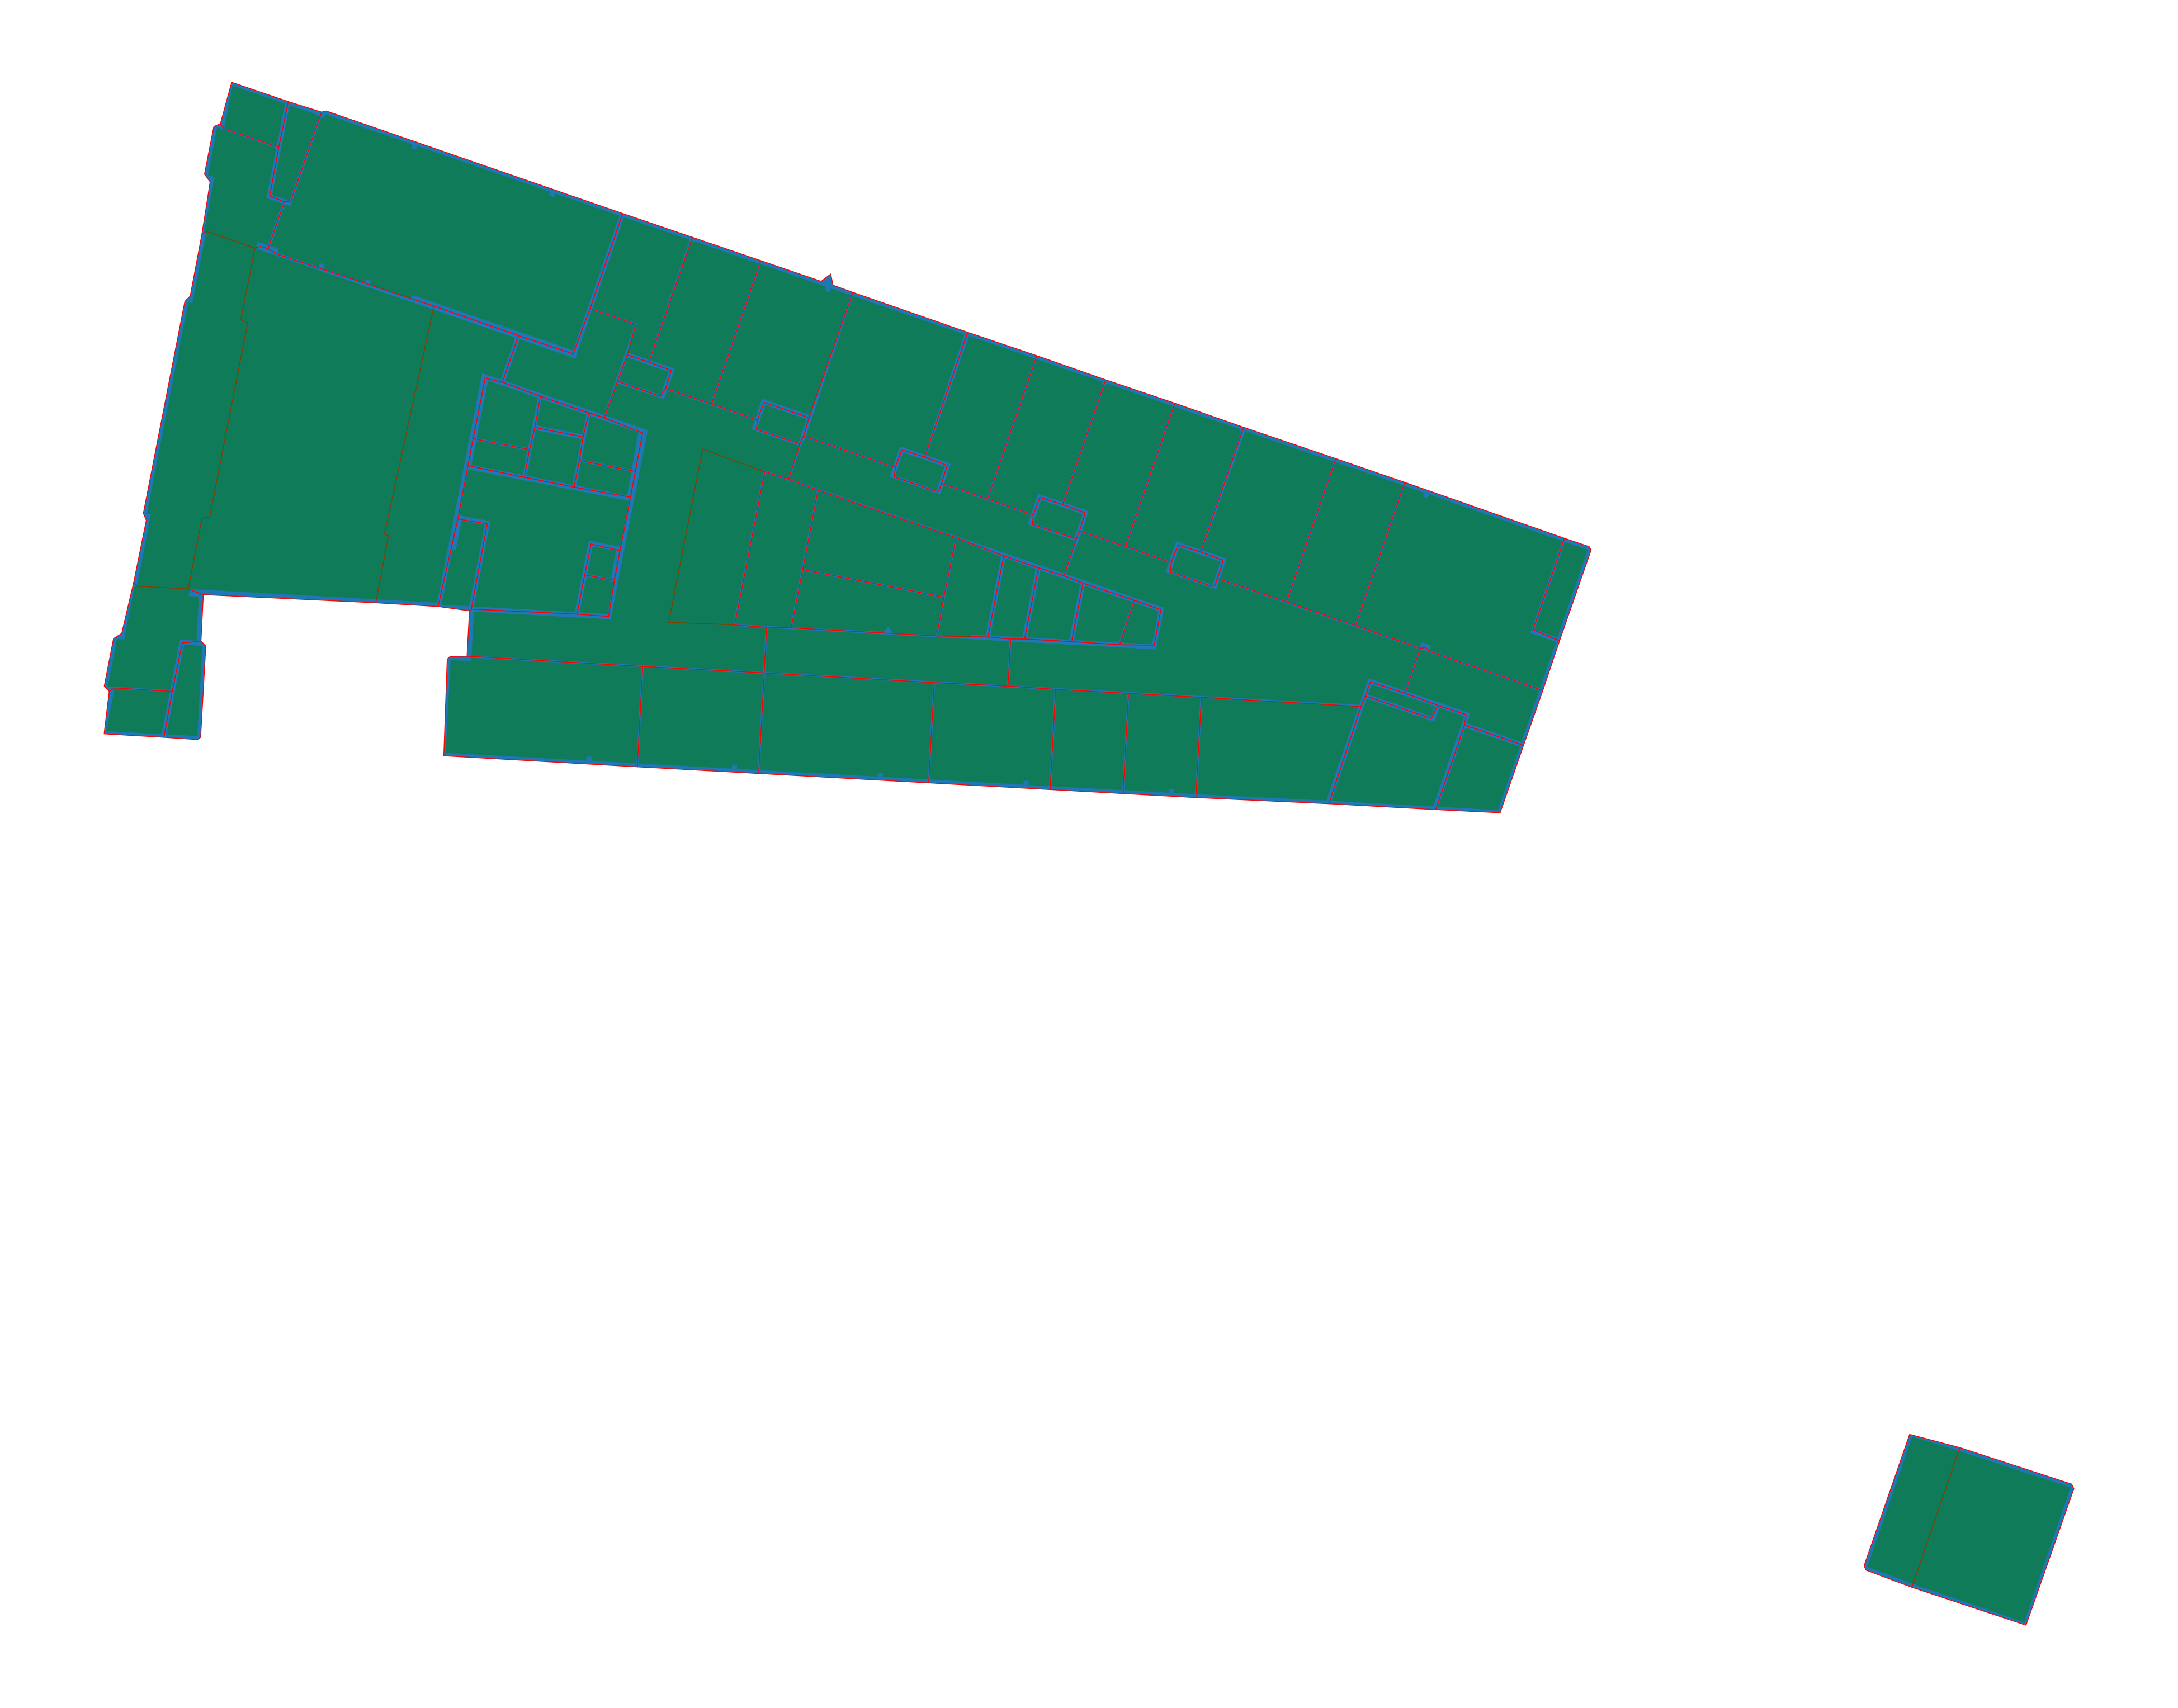

In [12]:
simplified_tessellation = tp.Topology(tessellation.geometry, prequantize=False).toposimplify(0.1).to_gdf()

ax = simplified_tessellation.plot(edgecolor="red", figsize=(50, 50))
spaces.plot(ax=ax, color="green", alpha=0.5)
ax.set_axis_off()

In [13]:
spaces["geometry"] = simplified_tessellation.geometry

In [14]:
spaces["geometry"]

68     POLYGON ((76517.833 77372.605, 76518.305 77374...
69     POLYGON ((76518.305 77374.861, 76517.833 77372...
70     POLYGON ((76517.833 77372.605, 76515.138 77373...
71     POLYGON ((76519.948 77374.343, 76518.425 77369...
72     POLYGON ((76536.085 77362.006, 76538.244 77368...
                             ...                        
127    POLYGON ((76574.15 77347.881, 76573.389 77345....
128    POLYGON ((76598.395 77301.552, 76600.767 77308...
129    POLYGON ((76516.652 77367.624, 76515.96 77364....
130    POLYGON ((76516.652 77367.624, 76514.274 77368...
131    POLYGON ((76600.767 77308.446, 76598.395 77301...
Name: geometry, Length: 64, dtype: geometry

In [15]:
doors["width_geom"] = doors["geometry"].minimum_bounding_circle().area.map(lambda a: 2 * math.sqrt(a / math.pi))
# ø = 2 · √(A / π)
doors["geometry"] = doors["geometry"].centroid
doors.drop("type", axis=1, inplace=True)
doors

metadata  height_geom  \
0   {'ADT_Pset_Door.OpenPercent': '50.0', 'ADT_Pse...        2.200   
1   {'ADT_Pset_Door.OpenPercent': '50.0', 'ADT_Pse...        2.200   
2   {'ADT_Pset_Door.OpenPercent': '50.0', 'ADT_Pse...        2.200   
3   {'ADT_Pset_Door.OpenPercent': '50.0', 'ADT_Pse...        2.200   
4   {'ADT_Pset_Door.OpenPercent': '50.0', 'ADT_Pse...        2.065   
..                                                ...          ...   
63  {'ADT_Pset_Door.OpenPercent': '0.0', 'ADT_Pset...        2.125   
64  {'ADT_Pset_Door.OpenPercent': '0.0', 'ADT_Pset...          NaN   
65  {'ADT_Pset_Door.OpenPercent': '0.0', 'ADT_Pset...          NaN   
66  {'ADT_Pset_Door.OpenPercent': '0.0', 'ADT_Pset...        2.800   
67  {'ADT_Pset_Door.OpenPercent': '0.0', 'ADT_Pset...          NaN   

                       geometry level  tid indoor  width_geom  
0   POINT (76532.376 77359.775)     3    0   door    0.688578  
1   POINT (76526.552 77349.866)     3    1   door    0.688578  
2   POINT (76533.351 77349.491)     3    2   door    0.688578  
3   POINT (76554.519 77352.172)     3    3   door    0.688578  
4   POINT (76558.083 77348.119)     3    4   door    0.918831  
..                          ...   ...  ...    ...         ...  
63  POINT (76576.799 77343.939)     3   63   door    0.998033  
64  POINT (76556.882 77352.373)     3   64   door    1.595640  
65   POINT (76534.19 77360.187)     3   65   door    1.595640  
66   POINT (76574.11 77347.763)     3   66   door    0.070484  
67  POINT (76543.267 77357.061)     3   67   door    1.595640  

[68 rows x 7 columns]

In [16]:
# spaces.drop(["type", "super_type", "sub_type_id", "sub_type"], axis=1, inplace=True)
spaces.drop(["type"], axis=1, inplace=True)
spaces

metadata  height_geom level  \
68   {'ADT_Pset_Door': None, 'ADT_Pset_DoorStyle': ...         3.15     3   
69   {'ADT_Pset_Door': None, 'ADT_Pset_DoorStyle': ...         3.60     3   
70   {'ADT_Pset_Door': None, 'ADT_Pset_DoorStyle': ...         3.15     3   
71   {'ADT_Pset_Door': None, 'ADT_Pset_DoorStyle': ...         3.15     3   
72   {'ADT_Pset_Door': None, 'ADT_Pset_DoorStyle': ...         3.15     3   
..                                                 ...          ...   ...   
127  {'ADT_Pset_Door': None, 'ADT_Pset_DoorStyle': ...         3.15     3   
128  {'ADT_Pset_Door': None, 'ADT_Pset_DoorStyle': ...         3.60     3   
129  {'ADT_Pset_Door': None, 'ADT_Pset_DoorStyle': ...         3.15     3   
130  {'ADT_Pset_Door': None, 'ADT_Pset_DoorStyle': ...         3.15     3   
131  {'ADT_Pset_Door': None, 'ADT_Pset_DoorStyle': ...         3.60     3   

     tid indoor                                           geometry  
68    68   room  POLYGON ((76517.833 77372.605, 76518.305 77374...  
69    69   room  POLYGON ((76518.305 77374.861, 76517.833 77372...  
70    70   room  POLYGON ((76517.833 77372.605, 76515.138 77373...  
71    71   room  POLYGON ((76519.948 77374.343, 76518.425 77369...  
72    72   room  POLYGON ((76536.085 77362.006, 76538.244 77368...  
..   ...    ...                                                ...  
127  127   room  POLYGON ((76574.15 77347.881, 76573.389 77345....  
128  128   room  POLYGON ((76598.395 77301.552, 76600.767 77308...  
129  129   room  POLYGON ((76516.652 77367.624, 76515.96 77364....  
130  130   room  POLYGON ((76516.652 77367.624, 76514.274 77368...  
131  131   room  POLYGON ((76600.767 77308.446, 76598.395 77301...  

[64 rows x 6 columns]

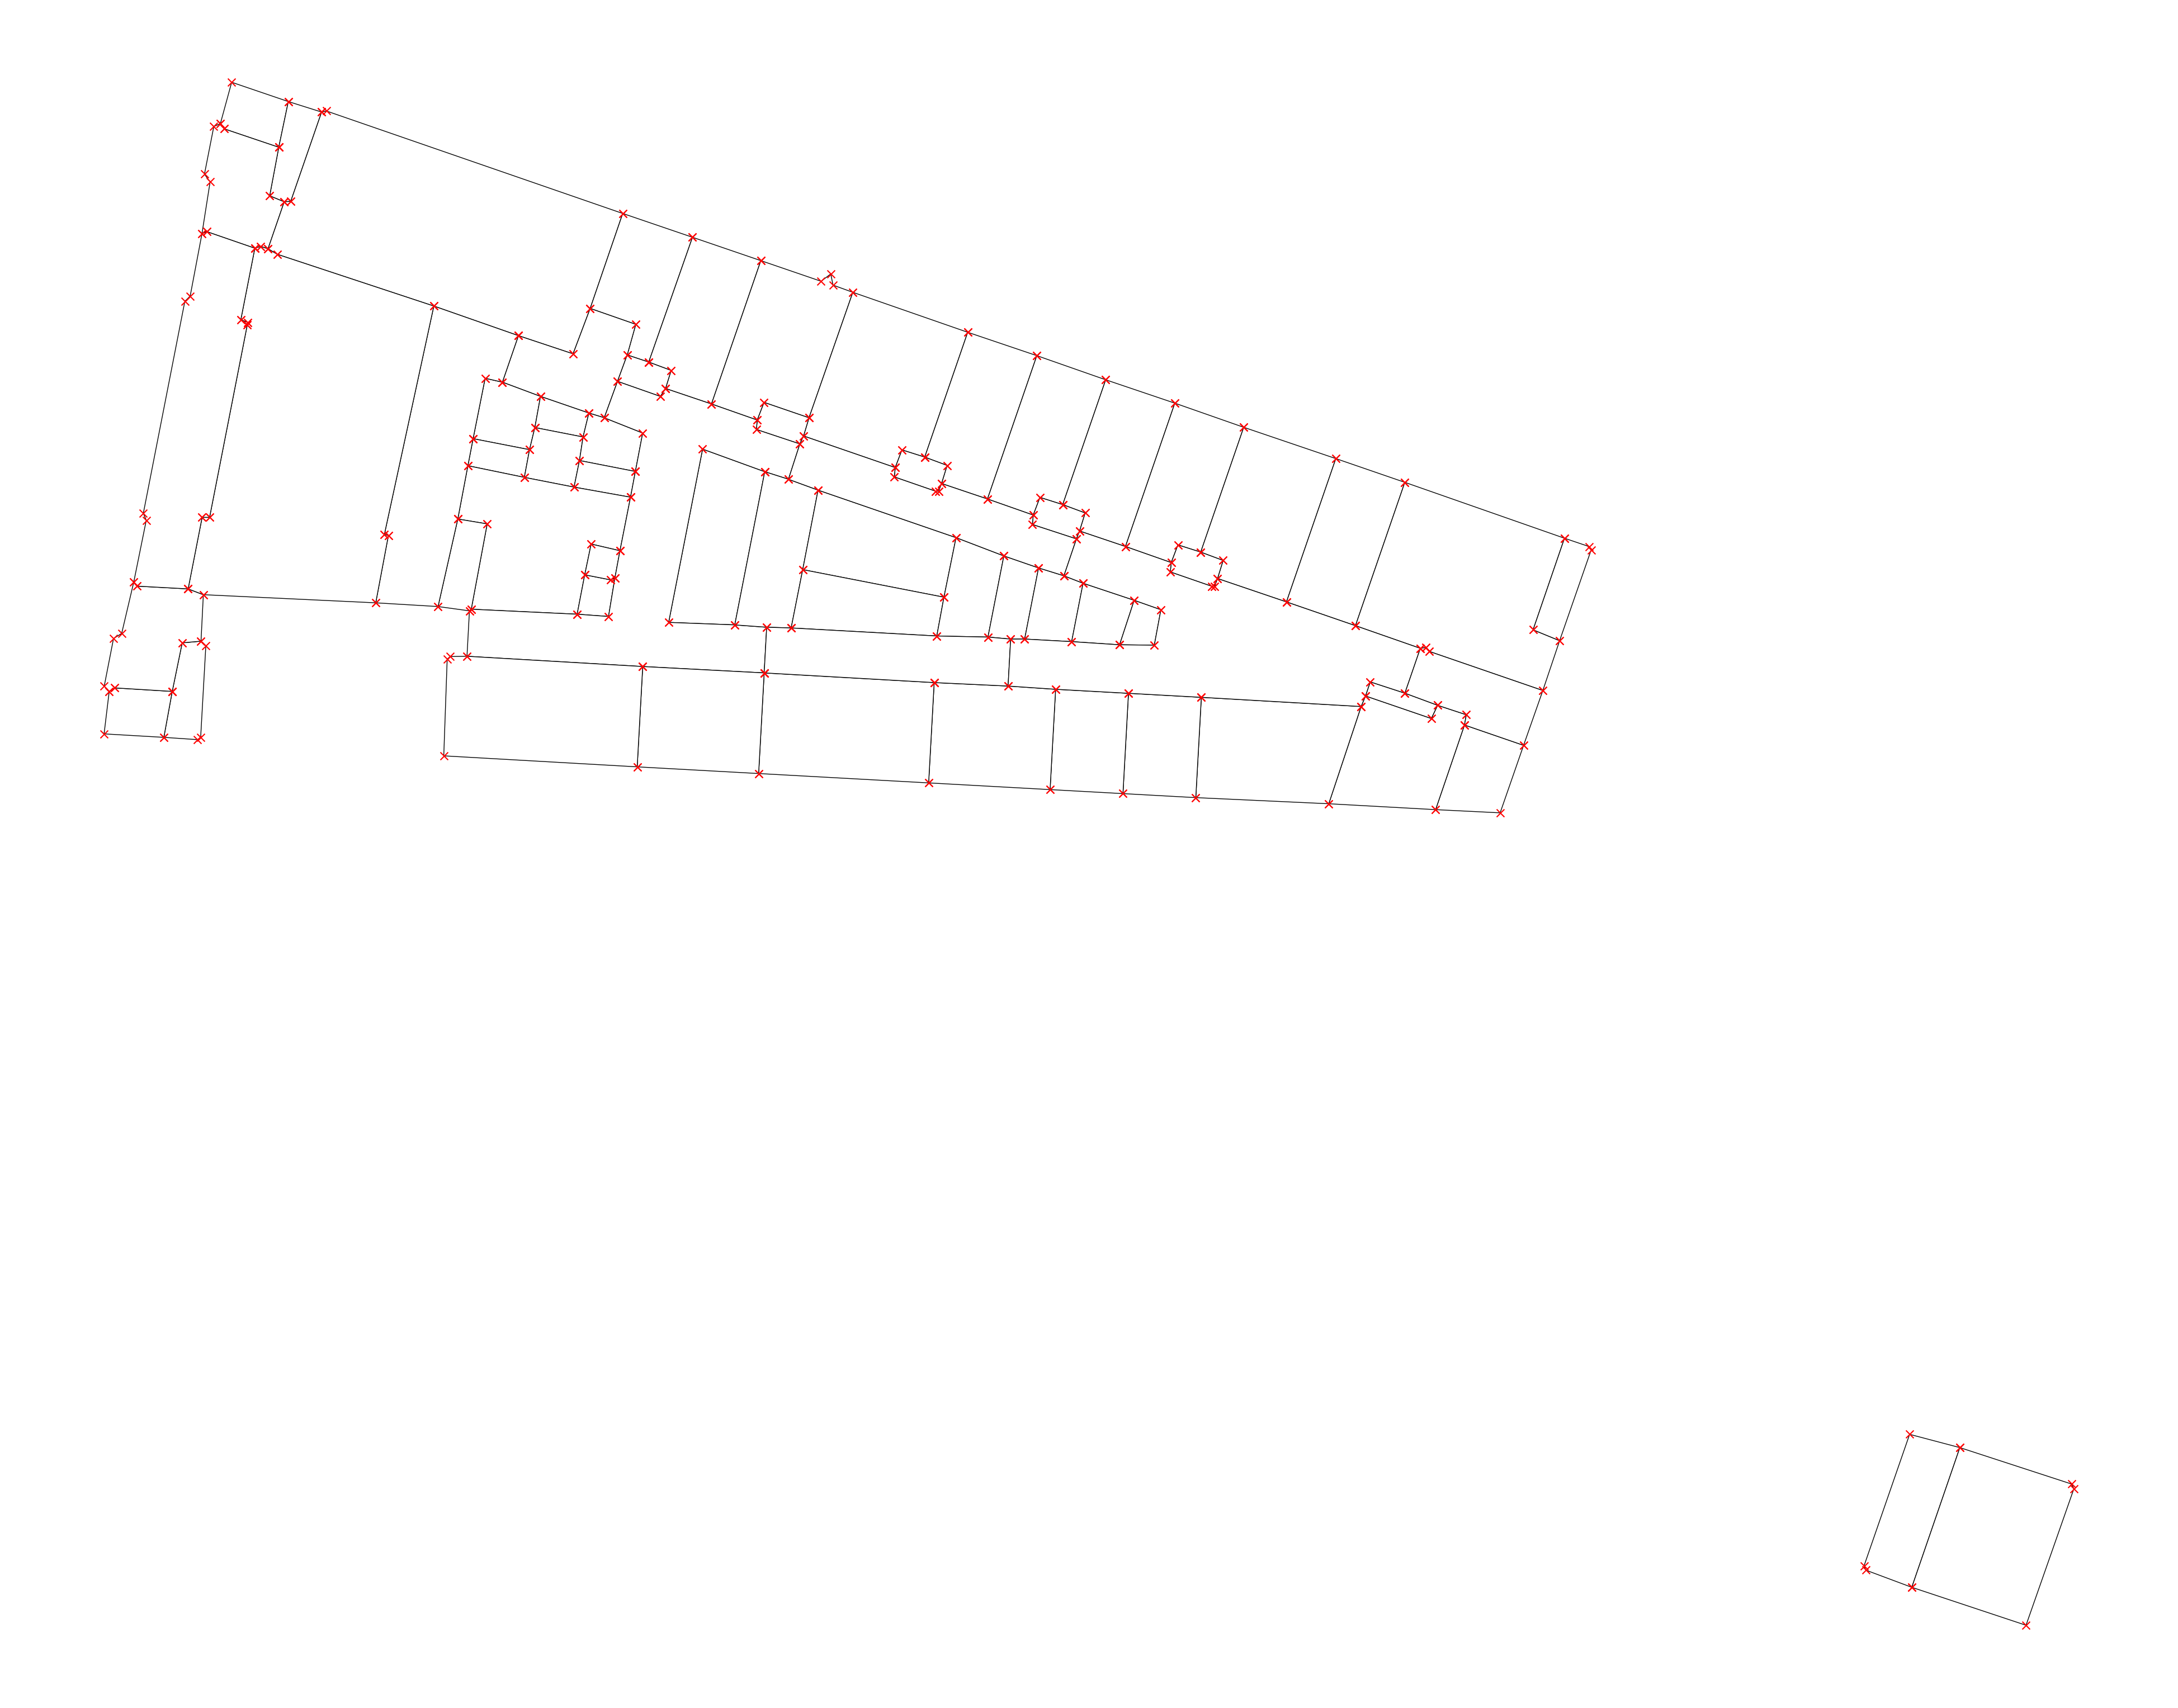

In [17]:
visualise_points()

In [18]:
for k, v in doors.metadata.iloc[0].items():
    print(k.rjust(50), v)

                         ADT_Pset_Door.OpenPercent 50.0
                                  ADT_Pset_Door.id 3849
              ADT_Pset_DoorStyle.AdjustToWallWidth True
                  ADT_Pset_DoorStyle.DoorThickness 0.03
                 ADT_Pset_DoorStyle.GlassThickness 0.003
   ADT_Pset_DoorStyle.IsBoundaryForAutomaticSpaces True
                      ADT_Pset_DoorStyle.StopDepth 0.06
                      ADT_Pset_DoorStyle.StopWidth 0.06
                             ADT_Pset_DoorStyle.id 3705
                                    ADT_Pset_Space None
                                           Fenster None
                                        Fenster.FM None
                                       Fenster.SAP None
                                       LiningDepth 0.03
                                   LiningThickness 0.06
                                        PanelDepth 0.03
                                    PanelOperation SWINGING
                                     PanelP

In [19]:
# is this door hinged?
doors["door"] = doors.metadata.map(lambda m: m.get("PanelOperation"))
doors["door"] = doors["door"].map(lambda d: {"SWINGING": "hinged", None: "yes"}[d])
doors.door = doors.door.astype("category")

In [20]:
def try_to_float(f: str | None) -> float | None:
    if f is None:
        return None
    try:
        return float(f)
    except ValueError:
        print(f"Could not convert '{f}' to float")
        return None


# geometry according to metadata
doors["height_meta"] = doors.metadata.map(lambda m: try_to_float(m.get("Türen.Höhe")))
doors["width_meta"] = doors.metadata.map(lambda m: try_to_float(m.get("Türen.Breite")))

In [21]:
doors

metadata  height_geom  \
0   {'ADT_Pset_Door.OpenPercent': '50.0', 'ADT_Pse...        2.200   
1   {'ADT_Pset_Door.OpenPercent': '50.0', 'ADT_Pse...        2.200   
2   {'ADT_Pset_Door.OpenPercent': '50.0', 'ADT_Pse...        2.200   
3   {'ADT_Pset_Door.OpenPercent': '50.0', 'ADT_Pse...        2.200   
4   {'ADT_Pset_Door.OpenPercent': '50.0', 'ADT_Pse...        2.065   
..                                                ...          ...   
63  {'ADT_Pset_Door.OpenPercent': '0.0', 'ADT_Pset...        2.125   
64  {'ADT_Pset_Door.OpenPercent': '0.0', 'ADT_Pset...          NaN   
65  {'ADT_Pset_Door.OpenPercent': '0.0', 'ADT_Pset...          NaN   
66  {'ADT_Pset_Door.OpenPercent': '0.0', 'ADT_Pset...        2.800   
67  {'ADT_Pset_Door.OpenPercent': '0.0', 'ADT_Pset...          NaN   

                       geometry level  tid indoor  width_geom    door  \
0   POINT (76532.376 77359.775)     3    0   door    0.688578  hinged   
1   POINT (76526.552 77349.866)     3    1   door    0.688578  hinged   
2   POINT (76533.351 77349.491)     3    2   door    0.688578  hinged   
3   POINT (76554.519 77352.172)     3    3   door    0.688578  hinged   
4   POINT (76558.083 77348.119)     3    4   door    0.918831  hinged   
..                          ...   ...  ...    ...         ...     ...   
63  POINT (76576.799 77343.939)     3   63   door    0.998033  hinged   
64  POINT (76556.882 77352.373)     3   64   door    1.595640     yes   
65   POINT (76534.19 77360.187)     3   65   door    1.595640     yes   
66   POINT (76574.11 77347.763)     3   66   door    0.070484     yes   
67  POINT (76543.267 77357.061)     3   67   door    1.595640     yes   

    height_meta  width_meta  
0         2.260        0.76  
1         2.260        0.76  
2         2.260        0.76  
3         2.260        0.76  
4         2.125        1.01  
..          ...         ...  
63        2.125        2.00  
64          NaN         NaN  
65          NaN         NaN  
66          NaN         NaN  
67          NaN         NaN  

[68 rows x 10 columns]

In [22]:
for dimension in ["height", "width"]:
    dimension_known = (doors[f"{dimension}_meta"] - doors[f"{dimension}_geom"]).abs() < 0.4
    doors[dimension] = doors[f"{dimension}_meta"]
    doors[dimension] = doors[dimension].where(dimension_known)
    doors.drop([f"{dimension}_meta", f"{dimension}_geom"], inplace=True, axis=1)

In [23]:
# doors.drop(["super_type", "sub_type_id"], inplace=True, axis=1)

In [24]:
spaces.metadata

68     {'ADT_Pset_Door': None, 'ADT_Pset_DoorStyle': ...
69     {'ADT_Pset_Door': None, 'ADT_Pset_DoorStyle': ...
70     {'ADT_Pset_Door': None, 'ADT_Pset_DoorStyle': ...
71     {'ADT_Pset_Door': None, 'ADT_Pset_DoorStyle': ...
72     {'ADT_Pset_Door': None, 'ADT_Pset_DoorStyle': ...
                             ...                        
127    {'ADT_Pset_Door': None, 'ADT_Pset_DoorStyle': ...
128    {'ADT_Pset_Door': None, 'ADT_Pset_DoorStyle': ...
129    {'ADT_Pset_Door': None, 'ADT_Pset_DoorStyle': ...
130    {'ADT_Pset_Door': None, 'ADT_Pset_DoorStyle': ...
131    {'ADT_Pset_Door': None, 'ADT_Pset_DoorStyle': ...
Name: metadata, Length: 64, dtype: object

In [25]:
for k, v in spaces.metadata.iloc[0].items():
    print(k.rjust(50), v)

    """

    Raum.Projekt.Geschoßbezeichnung None
    Raum.Projekt.Geschoßhöhe None
    Raum.Projekt.Geschoßniveau None

   Raum.Nummer 0533B
    Raum.RaumNR -0533B
    Raum.FM.Raum.ID 02-55-5505-100-533B

    Türen None
    Türen.FM None
    Türen.SAP None
    Türstil None"""

                                     ADT_Pset_Door None
                                ADT_Pset_DoorStyle None
                      ADT_Pset_Space.CeilingHeight 2.85
                   ADT_Pset_Space.CeilingThickness 0.0
                     ADT_Pset_Space.FloorThickness 0.1
                 ADT_Pset_Space.HeightAboveCeiling 0.1999999999999998
                   ADT_Pset_Space.HeightBelowFloor 0.0
                                 ADT_Pset_Space.id 153632
                                           Fenster None
                                        Fenster.FM None
                                       Fenster.SAP None
                    Raum.Abgehängte.Decke.Material None
                           Raum.AnrechenbareFläche 5.736417684464999
                          Raum.AnrechenbarerUmfang 9.70348245558547
                              Raum.Anrechenbarkeit 100
                                  Raum.Basisfläche 5.736417684464999
                                  Raum.Basisumfang 9.7

In [26]:
spaces["height_meta"] = spaces.metadata.map(lambda m: try_to_float(m.get("Raum.Lichte.Raumhöhe")))
spaces["height_meta2"] = spaces.metadata.map(lambda m: try_to_float(m.get("Raum.Gesamt.Raumhöhe")))
spaces["height_meta3"] = spaces.metadata.map(lambda m: try_to_float(m.get("ADT_Pset_Space.CeilingHeight")))

In [27]:
dimension_known = (spaces["height_meta"] - spaces["height_geom"]).abs() < 2.0
dimension_known &= (spaces["height_meta"] - spaces["height_meta2"]).abs() < 2.0
dimension_known &= (spaces["height_meta"] - spaces["height_meta3"]).abs() < 2.0

spaces["height"] = spaces["height_meta"]
spaces["height"] = spaces["height"].where(dimension_known)
spaces.drop(["height_meta", "height_meta2", "height_meta3", "height_geom"], inplace=True, axis=1)

In [28]:
spaces["ref"] = spaces.metadata.map(lambda m: m.get("Raum.Nummer"))
spaces["ref2"] = spaces.metadata.map(lambda m: m.get("Raum.RaumNR"))

RAUM_TO_SAP_LEVEL_LUT = {"100": "EG", "090": "U1", "110": "01", "120": "02", "130": "03"}


def to_tum_sap_raum_id(m: str | None) -> str | None:
    """02-55-5505-100-533B  -> 5505.EG.533B"""
    if m is None:
        return None
    r_parts = m.split("-")
    r_parts = r_parts[2:]
    if r_parts[1] not in RAUM_TO_SAP_LEVEL_LUT:
        raise ValueError(
            f"{r_parts[1]} (in room name {m}) is not a valid raum level. Please update RAUM_TO_SAP_LEVEL_LUT"
        )
    r_parts[1] = RAUM_TO_SAP_LEVEL_LUT[r_parts[1]]
    return ".".join(r_parts)


spaces["ref:tum"] = spaces.metadata.map(lambda m: to_tum_sap_raum_id(m.get("Raum.FM.Raum.ID")))

In [29]:
spaces["name_meta1"] = spaces.metadata.map(lambda m: m.get("Raum.Name"))
spaces["name_meta2"] = spaces.metadata.map(lambda m: m.get("Raum.FM.Raum.Name.Lang"))
spaces["name_meta3"] = spaces.metadata.map(lambda m: m.get("Raum.FM.Raum.Name.Z1"))
spaces["name_meta4"] = spaces.metadata.map(lambda m: m.get("Raum.FM.Raum.Name.Z2"))
spaces["name_meta5"] = spaces.metadata.map(lambda m: m.get("Raum.FM.Raum.Name.Z3"))

In [30]:
def any_name_eq(comp: str) -> gpd.GeoSeries:
    return (
            (spaces["name_meta1"] == comp)
            | (spaces["name_meta2"] == comp)
            | (spaces["name_meta3"] == comp)
            | (spaces["name_meta4"] == comp)
            | (spaces["name_meta5"] == comp)
    )


def any_name_like(comp: str) -> gpd.GeoSeries:
    return (
            spaces["name_meta1"].map(lambda n: n is not None and comp in n)
            | spaces["name_meta2"].map(lambda n: n is not None and comp in n)
            | spaces["name_meta3"].map(lambda n: n is not None and comp in n)
            | spaces["name_meta4"].map(lambda n: n is not None and comp in n)
            | spaces["name_meta5"].map(lambda n: n is not None and comp in n)
    )


is_corridor = any_name_eq("Flur") | any_name_like("Flure")
is_luft = any_name_eq("Luftflächen") | any_name_eq("Straße") | any_name_eq("Fahrzeugverkehrsfläche")
is_elevator = any_name_eq("Personenaufzug") | any_name_like("Hebebühne")
is_stair = any_name_eq("Treppenhaus") | any_name_eq("Treppe")

# sanity check: not-luft => ref2 is ref, but with a minus...
assert (is_luft | (spaces["ref"].map(lambda r: "-" + r if r else None) == spaces["ref2"])).all()
spaces.drop(["ref2"], inplace=True, axis=1)

spaces.drop(["name_meta1", "name_meta2", "name_meta3", "name_meta4", "name_meta5"], inplace=True, axis=1)

In [31]:
spaces["room"] = is_elevator.map(lambda b: "elevator" if b else None)
spaces.loc[is_stair, "room"] = "stairs"
spaces.loc[is_corridor, "indoor"] = "corridor"
spaces = spaces[~is_luft].copy(deep=True)

In [32]:
# final dropping of random junk
# spaces.drop(["metadata"], inplace=True, axis=1)
# doors.drop(["metadata"], inplace=True, axis=1)

In [33]:
df = gpd.GeoDataFrame(pd.concat([spaces, doors], ignore_index=True))
out = filename.replace(".parquet", ".geojson")
df_json: str = df.to_json(na="drop", drop_id=True, to_wgs84=True)
with open(out, "w") as f:
    f.write(df_json)

In [34]:
filename

'02-55-5505-130_3.OG.parquet'